In [1]:
import numpy as np

import random
from math import log10, sqrt
import cv2

# Helper Functions

In [166]:
def sort_revert(listn, indices_list = None):
    if indices_list is None:
        indices_list = list(range(len(listn)))
    sorted_indices = sorted(range(len(listn)), key=lambda i: listn[i])
    return (
        [listn[i] for i in sorted_indices],
        [indices_list[i] for i in sorted_indices]
    )

def revert_list(listn, indices_list):
    sorted_indices = sorted(range(len(indices_list)), key=lambda i: indices_list[i])
    sorted_first_list = [listn[i] for i in sorted_indices]
    return sorted_first_list

def to_binary(num, size):
    binary_list = []
    for _ in range(size):
        binary_list.append(0)

    index = size - 1
    while num > 0:
        binary_list[index] = num % 2
        num //= 2
        index -= 1

    return binary_list

def to_decimal(binary_list):
    binary_list = np.array(binary_list)
    decimal_value = 0
    for i, digit in enumerate(binary_list):
        if digit not in (0, 1):
            raise ValueError("Invalid binary digit: {}".format(digit))
        decimal_value += digit * (2 ** (len(binary_list) - i - 1))
    return decimal_value

def load_secret(secret):
    with open(secret, "r") as a:
        data = a.read()
        data = data.replace("\t", "")
        data = data.replace("\n", "")

    secret = list(map(int, data))
    # print(len(secret), "{:.2f}kb".format(bitToKb(len(secret) * 2)))
    return secret

def flip_lsb(num):
    return num ^ 1

def spread_array(arr: list[int], n: int):
    """
    Menyebarkan array dalam range 2^n
    :param arr: List nilai asli
    :param n: Pangkat dari 2^n
    :return: List nilai tersebar dan seed untuk pengembalian
    """
    seed = random.randint(0, 2**32 - 1)  # Tetapkan seed acak untuk reproducibility
    random.seed(seed)
    
    max_range = 2**n
    spread_values = [(a + random.randint(1, max_range - 1)) % max_range for a in arr]
    return spread_values, seed

def restore_array(spread_values, seed, n):
    """
    Mengembalikan array ke nilai asli
    :param spread_values: List nilai yang sudah disebar
    :param seed: Seed yang digunakan untuk penyebaran
    :param original_length: Panjang array asli
    :return: Array yang dikembalikan ke posisi asli (dummy nilai asli)
    """
    random.seed(seed)  # Set seed yang sama untuk reverse
    max_range = 2**n
    # Regenerate the same random numbers (this mimics the original array)
    spread_random = np.array([random.randint(1, 2**n - 1) for i in range(len(spread_values))])
    return list(map(lambda x: x[0] - x[1] + (max_range if x[0] < x[1] else 0), zip(spread_values, spread_random)))


## Evaluation Function

In [3]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

def MSE(original, compressed):
    mse = np.mean((original - compressed) ** 2) 
    return mse

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()  


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
from stego_functions import * 

# Embedding

## 1. Input
- Load Cover
- Load Secret

In [4]:
# cover_image = np.zeros((256, 256)) # use this for better embedding visualization

IMAGE_FILE = "images/256_Aerial_5.1.10.tiff"
image = cv2.imread(IMAGE_FILE)
cover_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

secret = load_secret("payload/random-base5_100kb.txt")

## 2. Process The Secret
- Calculate the Bit Count
- Sorting the secret
- Count Frequency of every elements in basis-b
- Embed the data

In [5]:
n = int(np.ceil(np.log2(cover_image.shape[0] * cover_image.shape[1])))
print(f'Bit Capacity: {n}')

Bit Capacity: 16


### Sorting the Secret & Count Frequency


In [6]:
s_sort, s_ind = sort_revert(secret)
s_sort = np.array(s_sort)

print("length:", len(s_sort))
print(s_sort)
print(s_ind)

length: 45000
[0 0 0 ... 4 4 4]
[2, 5, 6, 8, 12, 13, 15, 16, 17, 21, 27, 28, 29, 37, 39, 41, 42, 44, 45, 47, 49, 50, 55, 57, 59, 60, 62, 65, 67, 69, 72, 75, 80, 83, 86, 87, 89, 92, 96, 97, 101, 109, 111, 114, 116, 117, 118, 119, 122, 126, 127, 129, 135, 138, 153, 158, 164, 165, 170, 171, 175, 178, 181, 182, 187, 190, 191, 196, 198, 199, 203, 204, 205, 208, 211, 212, 213, 218, 221, 227, 234, 237, 238, 239, 247, 252, 262, 263, 264, 267, 270, 272, 275, 277, 283, 285, 287, 289, 291, 294, 300, 302, 310, 312, 313, 314, 318, 320, 321, 325, 326, 330, 331, 339, 343, 346, 349, 352, 356, 361, 362, 363, 366, 369, 370, 372, 375, 376, 383, 392, 395, 398, 400, 402, 405, 407, 409, 413, 419, 421, 422, 423, 424, 425, 426, 429, 435, 442, 443, 446, 458, 460, 461, 462, 463, 464, 466, 469, 474, 475, 481, 484, 487, 489, 492, 494, 495, 501, 503, 507, 509, 510, 511, 514, 516, 517, 522, 524, 526, 535, 537, 541, 547, 552, 553, 556, 558, 559, 560, 563, 564, 565, 568, 571, 575, 578, 579, 580, 581, 583, 584, 586, 5

In [7]:
u, q = np.unique(secret, return_counts=True)
q

array([ 9908, 10011,  9458,  7906,  7717], dtype=int64)

### Give random offset & sort it
Give random offset to the frequencies 

In [8]:
fa, seed = spread_array(q, n)
fa_sort, fa_ind = sort_revert(fa)
fa_sort = np.array(fa_sort)

print("length:", len(fa_sort))
print(fa_sort)
print(fa_ind)
print("seed:", seed)


length: 5
[ 5371  7685 33678 51462 62618]
[4, 1, 0, 2, 3]
seed: 398540676


In [9]:
# Test restore the array
restore_array(fa, seed, n)

[9908, 10011, 9458, 7906, 7717]

In [565]:
def spread_array_v2(arr: list[int], n: int):
    """
    Menyebarkan array dalam range 2^n
    :param arr: List nilai asli
    :param n: Pangkat dari 2^n
    :return: List nilai tersebar dan seed untuk pengembalian
    """
    seed = random.randint(0, 2**32 - 1)  # Tetapkan seed acak untuk reproducibility
    random.seed(seed)
    
    max_range = 2**n
    spread_values = [(a + random.randint(0, max_range - 1)) % max_range for a in arr]
    return spread_values, seed

def restore_array_v2(spread_values, seed, n):
    """
    Mengembalikan array ke nilai asli
    :param spread_values: List nilai yang sudah disebar
    :param seed: Seed yang digunakan untuk penyebaran
    :param original_length: Panjang array asli
    :return: Array yang dikembalikan ke posisi asli (dummy nilai asli)
    """
    random.seed(seed)  # Set seed yang sama untuk reverse
    max_range = 2**n
    # Regenerate the same random numbers (this mimics the original array)
    spread_random = np.array([random.randint(0, 2**n - 1) for i in range(len(spread_values))])
    return list(map(lambda x: x[0] - x[1] + (max_range if x[0] < x[1] else 0), zip(spread_values, spread_random)))

In [590]:
# arr = np.random.randint(0, 2**10, size=2**cn)
arr = [2,2,2,3,3,3,6,8]
a, b = spread_array_v2(arr, 3)
print(a, b, len(a))

re = restore_array_v2(a, b, 3)
# Bandingkan elemen per elemen antara a dan re, lalu hitung persentasenya
a_np = np.array(arr)
re_np = np.array(re)
sama = a_np == re_np
persentase = np.sum(sama) / len(a_np) * 100
print(sama, f'percentage: {persentase}%')
print(sum(pd.DataFrame(a).duplicated()))
print(re)

[7, 2, 3, 7, 2, 2, 6, 2] 493977363 8
[ True  True  True  True  True  True  True False] percentage: 87.5%
4
[2, 2, 2, 3, 3, 3, 6, 0]


In [10]:
# massive test for the spread_array and reverse_array
# success rate 100% as long the 2^n > the datas
import numpy as np
import random
import pandas as pd

cn = 10
sample_test = 10
success = 0

for _ in range(sample_test):
    # arr = np.random.random_integers(0, 10000, size=10)
    arr = np.random.random_integers(0, 1024, size=100)
    a, b = spread_array_v2(arr, cn)
    res = restore_array_v2(a, b, cn)
    success += np.array_equal(res, arr)
    # print(success)
    print(sum(pd.DataFrame(a).duplicated()))
    # print(arr, res)

str(success*100/sample_test) + "%"


C:\Users\WIN-11\AppData\Local\Temp\ipykernel_26396\3878660737.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 1024 + 1) instead
  arr = np.random.random_integers(0, 1024, size=100)


0
0
0
0
0
0
0
0
0
0


'0.0%'

### Embedding

#### Embedding Process
Flip the LSB of index that is in the list of random spread frequency array

In [11]:
embedded_image = cover_image.copy().flatten().astype(np.uint8)
embedded_image_size = embedded_image.shape[0]

In [12]:
for i in fa:
    embedded_image[i] = flip_lsb(embedded_image[i])


## 3. Create Error Correction

!BAKAL ADA ERROR \
lsb_bits = np.pad(lsb_bits, (0, 8 - len(lsb_bits) % 8), mode='constant') \
padding dalam extraction tidak di perhitungkan \
SAMPAI SEKARANG BELOM ADA ERROR KARENA IMAGE SELALU KELIPATAN 2 (256 x 256) atau (512 x 512)

In [13]:
# take the lsb 8 bit (1 byte)

def image_to_byte(image):
    # Step 1: Extract the least significant bit (LSB) from each index
    lsb_bits = image.astype(np.uint8) & 1
    lsb_bits = (lsb_bits).astype(np.uint8)

    # Step 2: Convert the LSBs into an 8-bit byte array
    # Ensure the number of bits is a multiple of 8
    if len(lsb_bits) % 8 != 0:
        lsb_bits = np.pad(lsb_bits, (0, 8 - len(lsb_bits) % 8), mode='constant')

    # Convert the bits into bytes
    return np.packbits(lsb_bits).tobytes()

def count_differing_bytes(cover_image, embedded_image):
    # Convert both images to byte arrays
    cover_bytes = image_to_byte(cover_image)
    embedded_bytes = image_to_byte(embedded_image)

    # Ensure both byte arrays are of the same length
    if len(cover_bytes) != len(embedded_bytes):
        raise ValueError("The cover and embedded images must have the same number of bytes after conversion.")

    # Count the number of differing bytes
    differing_count = sum([1 for c, e in zip(cover_bytes, embedded_bytes) if c != e])

    return differing_count

print(image_to_byte(cover_image))
# print(byte_array)

b'\x06\xfeU0L\x8b3\x19\xc6\x98\x96\x88\xd4\x94\xa5\xa3\x07\xf4Q\xe7\xb7\xca\x8dv\xaa$\x0b\xa3\xef\xc5T|\x8e\x1d\xbf\xe41|\x04\x10[o\xc3z\x91e\x14\xd0\xc3\xd5\xf2\x9d*\xdfa-\xc4\x91\x00\xaf-\xe7X20\x9c6\x00\xd4_N\x8d\x02\xf4\xb4\x15\xa0\\$\xb1\xa5zd\x0eg`\xa6\x1d\xcc\x07\\\xd2$\x08=R\xb2bQp\x19\x04\x88\n5~\xb5\xf2\x95\xab\xc7$Z\x8e<l<AJN\xad\xe2\x95\x8a\xd1$\xa8T\xbc\x1e~0u\x1e\xb7\xa8|\xacu\xf8O>\x8b1\x9f\x9d|\xa5\x00\x80\x96dT\x86\xf4\xc9\xca-F\xb1e\xfe\xd01\xdb\xbf\x9cF\xe6\xf7\xb4\xfbV\n7\x01\xa3\xd2 \t!\xe7\x85*\x80\xb2+\xa6\x9d\x94\x92\xb0\xfb\x00g\xde\x08\xe1\x05\xd3\xb2E\xa2{.\x91q\xb6U\x03)\x7f*\xd0\n*\xd2\x07\xc8\x0c\x88\xc6AD\x02j\xc7\x07\xec\xbc\xc4*\xdf\xbe\x1aDa\xb0\xfc\x04\xac\x08\xac\x9e_\xc0\x86}[^|DH5\xd6\xa8l\xd1\x0fV\xfe:\xb30Mc\x998\xfdm\xfa\xe7\x87D\x82\xbc\x0e\xa2\x12-\xfb\x14\xd5\x06\x82\x91\xe1\xb4\x15\x99\x04\xe6 \xf3O\x1d\xd4\xfd\x99\xb2\x81B\x8d\xfb\xe6R\xb1\x8d\xae\xa1o\xa2-S?U\xf8\xae0{\xcb?sa\x8a=\xc2\xc7\xa4P@\xe6\xd1:-)\x1f\x00Qf\x97\xdc\xf3,\x9d\x04[\xa

In [14]:
# prompt: create for me reed solomon error correction with base 16 number, with totally 2^16 wrror

import numpy as np
import reedsolo
from random import randint
from math import log10, sqrt
import matplotlib.pyplot as plt

MAX_PARITY = 128
rs254 = reedsolo.RSCodec(MAX_PARITY)

# Convert embedded_image to bytes
cover_bytes = image_to_byte(cover_image)

encoded_bytes = bytearray()
parity_array = bytearray()
for i in range(0, len(cover_bytes), MAX_PARITY//2):
    chunk = cover_bytes[i:i+MAX_PARITY//2]
    print(len(chunk))
    
    if len(chunk) < MAX_PARITY//2:
        rs = reedsolo.RSCodec(len(chunk) * 2)
        encoded_chunk = rs.encode(chunk)
        print("encoded length:",  len(encoded_chunk))
        encoded_bytes.extend(encoded_chunk)
    else:
        encoded_chunk = rs254.encode(chunk)
        print("encoded length:",  len(encoded_chunk))
        encoded_bytes.extend(encoded_chunk)

    parity_key = encoded_chunk[len(chunk):]
    parity_array.extend(parity_key)
        
    
le = len(cover_bytes)
((le // 127) * 254) + (le % 127) * 3, len(encoded_bytes), len(parity_array)


64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded length: 192
64
encoded 

(16448, 24576, 16384)

In [15]:
len(cover_bytes)

8192

## Evaluation
- PSNR
- SSIM

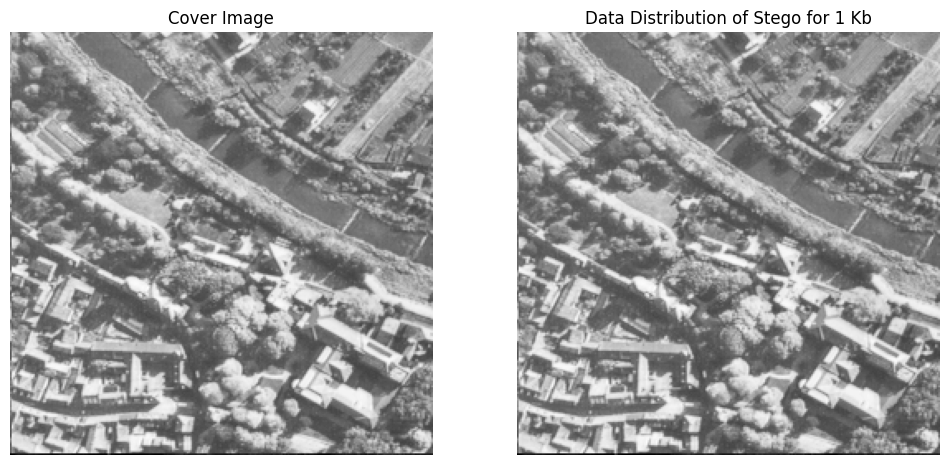

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(cover_image.reshape(256,256), cmap="gray")
axs[0].axis('off')
axs[0].set_title('Cover Image')
axs[1].imshow(embedded_image.reshape(256,256), cmap="gray")
axs[1].axis('off')
axs[1].set_title('Data Distribution of Stego for 1 Kb')
plt.show()

In [17]:
print("PSNR:", PSNR(cover_image.flatten(), embedded_image))
print("SSIM:", ssim(cover_image, embedded_image.reshape(256,256)))

PSNR: 89.3059028715559
SSIM: 0.9999999134397547


# Extraction

## 1. Input
- Load KEY 1 from (offset, order) from the embedding process
- Load KEY 2 from parity key
- Load stego image

In [18]:
KEY1 = seed
KEY2 = s_ind
KEY3 = fa_ind
KEY4 = parity_array
STEGO = embedded_image

MAX_PARITY = 128

## 2. Recover Original Images
- Take the KEY 4 (Parity Key)
- Reconstruct the block (every 128 parity bytes correspond to 64 data bytes)
- decode the parity bytes to get the original data bytes



In [19]:
MAX_PARITY = 128
rs254 = reedsolo.RSCodec(MAX_PARITY)

# Convert embedded_image to bytes
stego_bytes = image_to_byte(STEGO)

reconstructed_cover_bytes = bytes()
for i in range(0, len(KEY2), MAX_PARITY):
    parity = KEY4[i:i+MAX_PARITY]

    block = stego_bytes[i//2:i//2+MAX_PARITY//2] + parity

    if len(parity) < MAX_PARITY:
        rs = reedsolo.RSCodec(len(parity))
        decoded = rs.decode(block)[0]
        reconstructed_cover_bytes += decoded[:len(parity)//2]
    else:
        decoded = rs254.decode(block)[0]
        reconstructed_cover_bytes += decoded[:MAX_PARITY//2]
    
len(reconstructed_cover_bytes)


8192

In [20]:
# check if the cover is recovered perfectly
cover = np.frombuffer(cover_bytes, dtype=np.int8)
r_cover = np.frombuffer(reconstructed_cover_bytes, dtype=np.int8)

print("PSNR:", PSNR(cover, r_cover))

sum(np.equal(cover, r_cover)) / len(cover)

PSNR: 100


1.0

## 3. Recover the secret key
- take the reconstructed cover bytes and do bitwise xor with the stego image to get where the index which was part of secret key is hidden

### 1. Get flagged indices

In [21]:
stego = np.frombuffer(stego_bytes, dtype=np.uint8)
r_cover = np.frombuffer(reconstructed_cover_bytes, dtype=np.uint8)

# take the non-zero indices of the difference
diff = np.bitwise_xor(stego, r_cover)
non_zero_indices = np.where(diff != 0)[0]
print(diff[non_zero_indices])

# convert it into binary
secret_indices = np.array([])
for i, v in enumerate(diff[non_zero_indices]):
    binary = np.array(to_binary(v, 8))
    idx = np.where(binary == 1)[0] + (non_zero_indices[i] * 8) # 8 is bit
    print(v, type(binary), np.where(binary == 1)[0], idx, non_zero_indices[i] * 8)
    secret_indices = np.append(secret_indices, idx)

secret_indices

[16  4  2  2 32]
16 <class 'numpy.ndarray'> [3] [5371] 5368
4 <class 'numpy.ndarray'> [5] [7685] 7680
2 <class 'numpy.ndarray'> [6] [33678] 33672
2 <class 'numpy.ndarray'> [6] [51462] 51456
32 <class 'numpy.ndarray'> [2] [62618] 62616


array([ 5371.,  7685., 33678., 51462., 62618.])

In [22]:
# make sure the indices we got is the same
f_revert_ori= revert_list(secret_indices, KEY3)
fa_restore = restore_array(f_revert_ori, KEY1, n)
f_revert_ori, fa_restore

([33678.0, 7685.0, 51462.0, 62618.0, 5371.0],
 [9908.0, 10011.0, 9458.0, 7906.0, 7717.0])

### 2. Reverse the order to original and subtract the offset
- using KEY1 to revert the order
- subtracting the offset from the result

In [23]:
s_sorted_extract = np.concatenate([ [idx] * int(i) for idx, i in enumerate(fa_restore) ])
s_sorted_extract


array([0, 0, 0, ..., 4, 4, 4])

### 3. Recover the secret data

In [24]:
recovered_secret_data = np.array(revert_list(s_sorted_extract, KEY2))

In [25]:
# check if the binary secret data is the same
recovered_secret_data, np.array(secret)

(array([1, 2, 0, ..., 0, 4, 1]), array([1, 2, 0, ..., 0, 4, 1]))

In [26]:
# check if the secret is fully recovered
t = np.equal(recovered_secret_data, secret)
t, f'percentage: {(sum(t)/len(t)) * 100}%'

(array([ True,  True,  True, ...,  True,  True,  True]), 'percentage: 100.0%')

## 1. Input
- Load KEY 1 from (offset, order) from the embedding process
- Load KEY 2 from parity key
- Load stego image

In [27]:
KEY1 = seed
KEY2 = s_ind
KEY3 = fa_ind
KEY4 = parity_array
STEGO = embedded_image

MAX_PARITY = 128

## 2. Recover Original Images
- Take the KEY 4 (Parity Key)
- Reconstruct the block (every 128 parity bytes correspond to 64 data bytes)
- decode the parity bytes to get the original data bytes



In [28]:
MAX_PARITY = 128
rs254 = reedsolo.RSCodec(MAX_PARITY)

# Convert embedded_image to bytes
stego_bytes = image_to_byte(STEGO)

reconstructed_cover_bytes = bytes()
for i in range(0, len(KEY2), MAX_PARITY):
    parity = KEY4[i:i+MAX_PARITY]

    block = stego_bytes[i//2:i//2+MAX_PARITY//2] + parity

    if len(parity) < MAX_PARITY:
        rs = reedsolo.RSCodec(len(parity))
        decoded = rs.decode(block)[0]
        reconstructed_cover_bytes += decoded[:len(parity)//2]
    else:
        decoded = rs254.decode(block)[0]
        reconstructed_cover_bytes += decoded[:MAX_PARITY//2]
    
len(reconstructed_cover_bytes)


8192

In [29]:
# check if the cover is recovered perfectly
cover = np.frombuffer(cover_bytes, dtype=np.int8)
r_cover = np.frombuffer(reconstructed_cover_bytes, dtype=np.int8)

print("PSNR:", PSNR(cover, r_cover))

sum(np.equal(cover, r_cover)) / len(cover)

PSNR: 100


1.0

## 3. Recover the secret key
- take the reconstructed cover bytes and do bitwise xor with the stego image to get where the index which was part of secret key is hidden

### 1. Get flagged indices

In [30]:
stego = np.frombuffer(stego_bytes, dtype=np.uint8)
r_cover = np.frombuffer(reconstructed_cover_bytes, dtype=np.uint8)

# take the non-zero indices of the difference
diff = np.bitwise_xor(stego, r_cover)
non_zero_indices = np.where(diff != 0)[0]
print(diff[non_zero_indices])

# convert it into binary
secret_indices = np.array([])
for i, v in enumerate(diff[non_zero_indices]):
    binary = np.array(to_binary(v, 8))
    idx = np.where(binary == 1)[0] + (non_zero_indices[i] * 8) # 8 is bit
    print(v, type(binary), np.where(binary == 1)[0], idx, non_zero_indices[i] * 8)
    secret_indices = np.append(secret_indices, idx)

secret_indices

[16  4  2  2 32]
16 <class 'numpy.ndarray'> [3] [5371] 5368
4 <class 'numpy.ndarray'> [5] [7685] 7680
2 <class 'numpy.ndarray'> [6] [33678] 33672
2 <class 'numpy.ndarray'> [6] [51462] 51456
32 <class 'numpy.ndarray'> [2] [62618] 62616


array([ 5371.,  7685., 33678., 51462., 62618.])

In [31]:
# make sure the indices we got is the same
f_revert_ori= revert_list(secret_indices, KEY3)
fa_restore = restore_array(f_revert_ori, KEY1, n)
f_revert_ori, fa_restore

([33678.0, 7685.0, 51462.0, 62618.0, 5371.0],
 [9908.0, 10011.0, 9458.0, 7906.0, 7717.0])

### 2. Reverse the order to original and subtract the offset
- using KEY1 to revert the order
- subtracting the offset from the result

In [32]:
s_sorted_extract = np.concatenate([ [idx] * int(i) for idx, i in enumerate(fa_restore) ])
s_sorted_extract


array([0, 0, 0, ..., 4, 4, 4])

### 3. Recover the secret data

In [33]:
recovered_secret_data = np.array(revert_list(s_sorted_extract, KEY2))

In [34]:
# check if the binary secret data is the same
recovered_secret_data, np.array(secret)

(array([1, 2, 0, ..., 0, 4, 1]), array([1, 2, 0, ..., 0, 4, 1]))

In [35]:
# check if the secret is fully recovered
t = np.equal(recovered_secret_data, secret)
t, f'percentage: {(sum(t)/len(t)) * 100}%'

(array([ True,  True,  True, ...,  True,  True,  True]), 'percentage: 100.0%')